In [191]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pandas as pd
import scanpy as sc

In [51]:
with open("mean_and_stdev_GSE174188.csv", 'r') as file:
    df = pd.read_csv(file, index_col = 0)
    
healthy = sc.read_h5ad("GSE174188/GSE174188_Healthy.h5ad")
healthy

AnnData object with n_obs × n_vars = 486418 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status', 'cell_type'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [52]:
df

,age,mean_NK,mean_CD4T,mean_CD8T,mean_B,mean_Monocyte,mean_DC,std_NK,std_CD4T,std_CD8T,std_B,std_Monocyte,std_DC
HC-519,21.0,4.314572,2.133783,2.541044,2.215008,4.253415,0.955883,0.749347,0.353081,0.584568,0.393406,0.637790,0.118725
HC-520,22.0,7.153296,3.301596,3.623819,3.417949,5.683097,2.127246,1.075921,0.482696,0.534613,0.643028,0.588125,0.341599
IGTB1974_IGTB1974,23.0,6.240312,3.362070,3.934211,3.586159,5.945434,1.678427,0.715059,0.403406,0.749296,0.694991,0.680489,0.182131
IGTB1916_IGTB1916,23.0,6.880955,3.331587,4.258295,3.541119,5.522082,1.260744,0.729470,0.341525,0.502310,0.471973,0.672437,0.190104
IGTB1987_IGTB1987,23.0,7.512489,3.378382,3.627870,3.844986,5.890706,1.375918,0.796269,0.332629,0.541650,0.573292,0.713794,0.174472
...,...,...,...,...,...,...,...,...,...,...,...,...,...
HC-540,68.0,7.208837,3.344849,3.248580,2.823516,4.768369,0.810205,1.062078,0.568459,0.532761,0.497388,0.852107,0.109943
HC-536,71.0,7.569259,3.111927,3.789331,3.000617,4.916469,0.894743,0.831347,0.479433,0.538535,0.471832,0.625976,0.123043
HC-524,73.0,6.719375,2.766531,2.898888,2.875474,4.815088,1.840851,0.730996,0.472372,0.482450,0.642658,0.790643,0.326397
HC-022,74.0,5.529320,3.158104,3.673651,2.728781,4.927634,1.145823,0.754341,0.674691,0.649673,0.637683,0.604755,0.164673


In [53]:
sample = list(set(healthy.obs.ind_cov))

rows_to_remove = []
for i in sample:
    healthy = healthy[healthy.obs.Status == "Healthy", :]
    if healthy[healthy.obs.ind_cov == i,:].n_obs < healthy.n_obs*0.005:
        rows_to_remove.append(i)
    healthy_filter = healthy[~healthy.obs.ind_cov.isin(rows_to_remove),:]    
    
healthy_filter

View of AnnData object with n_obs × n_vars = 474740 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status', 'cell_type'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [71]:
df_healthy = pd.DataFrame(healthy_filter.X, columns = healthy_filter.var_names, index = healthy_filter.obs_names)

In [82]:
df_healthy["ID"] = healthy_filter.obs.ind_cov
df_healthy["cell_type"] = healthy_filter.obs.cell_type
df_healthy["cell_dispersion"] = 0

# 要移除的文字列表
texts_to_remove = ['PB', 'Progen', 'Prolif']
# 確保 'cell_type' 是字符串類型
df_healthy['cell_type'] = df_healthy['cell_type'].astype(str)
# 移除 'cell_type' 包含上述文字的行
df_healthy = df_healthy[~df_healthy['cell_type'].str.contains('|'.join(texts_to_remove))]
# 將 'cell_type' 轉換回 'CategoricalDtype'
df_healthy.loc[:, 'cell_type'] = pd.Categorical(df_healthy['cell_type'])


# 這是Y
#df_healthy["Age"] = healthy_filter.obs.Age

C:\Users\benson\AppData\Local\Temp\ipykernel_244572\93682178.py:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_healthy.loc[:, 'cell_type'] = pd.Categorical(df_healthy['cell_type'])


In [84]:
for i in df.index:    
    for j in df_healthy.index:
        if df_healthy.loc[j, 'ID'] == i and df_healthy.loc[j, 'cell_type'] == 'NK':
            df_healthy.loc[j, 'cell_dispersion'] = df.loc[i, 'mean_NK']
        elif df_healthy.loc[j, 'ID'] == i and df_healthy.loc[j, 'cell_type'] == 'DC':
            df_healthy.loc[j, 'cell_dispersion'] = df.loc[i, 'mean_DC']
        elif df_healthy.loc[j, 'ID'] == i and df_healthy.loc[j, 'cell_type'] == 'CD4 T':
            df_healthy.loc[j, 'cell_dispersion'] = df.loc[i, 'mean_CD4T']
        elif df_healthy.loc[j, 'ID'] == i and df_healthy.loc[j, 'cell_type'] == 'CD8 T':
            df_healthy.loc[j, 'cell_dispersion'] = df.loc[i, 'mean_CD8T']
        elif df_healthy.loc[j, 'ID'] == i and df_healthy.loc[j, 'cell_type'] == 'B':
            df_healthy.loc[j, 'cell_dispersion'] = df.loc[i, 'mean_B']
        elif df_healthy.loc[j, 'ID'] == i and df_healthy.loc[j, 'cell_type'] == 'Monocyte':
            df_healthy.loc[j, 'cell_dispersion'] = df.loc[i, 'mean_Monocyte']

In [86]:
# 將 DataFrame 輸出為 CSV 檔案
df_healthy.to_csv('data_for_model_still_have_str.csv', index=True)

In [91]:
df_healthy

,HES4,ISG15,TNFRSF18,TNFRSF4,MIB2,MMP23B,PLCH2,UTS2,ERRFI1,RBP7,...,DIP2A,S100B,PRMT2,MT-ATP8,MT-ND6,AL592183.1,KIR2DL2,ID,cell_type,cell_dispersion
CAAGGCCAGTATCGAA-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0,-0.216634,-0.842700,-0.111585,-0.129625,-0.223780,-0.092845,-0.034995,-0.151906,-0.030994,-0.360888,...,-0.186963,-0.127499,1.532912,-0.161378,-0.258246,2.016497,-0.069288,0,0,2.657702
GAACATCCAGCTATTG-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,-0.186630,-0.643361,-0.119131,-0.158770,-0.252590,-0.093595,-0.061074,-0.161825,-0.040961,-0.254984,...,-0.214708,-0.149836,-0.512312,-0.158235,-0.318423,-0.392112,-0.054628,1,0,3.049267
TACCTATTCTACTATC-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,-0.093546,-0.577507,-0.116917,-0.116756,-0.185430,-0.077310,-0.044767,-0.113865,-0.027142,-0.230567,...,-0.187046,-0.148082,-0.434764,-0.215320,-0.310015,-0.338559,-0.050765,2,1,3.067722
GTCATTTCAGAGTGTG-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0,-0.178964,-0.710476,-0.128105,-0.169097,-0.236433,-0.097835,-0.048998,-0.164765,-0.039262,-0.285568,...,-0.196149,-0.131671,-0.468593,-0.143633,-0.262800,-0.357601,-0.093447,3,0,3.344849
AAAGATGGTTCACGGC-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0-0-0-0,-0.179494,-0.572793,-0.139508,-0.161891,-0.250389,-0.105592,-0.038064,-0.129548,-0.022998,-0.261198,...,-0.205200,-0.129643,-0.569169,-0.157559,-0.316534,-0.407982,-0.070964,4,0,3.334686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCTCAGTCAGCTGTAT-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,-0.219326,-0.127115,-0.143038,-0.155148,-0.280913,-0.124353,-0.057018,-0.126332,-0.046493,1.495293,...,2.816405,-0.159388,0.638974,1.896922,1.789076,-0.450759,-0.065332,18,3,5.027587
ATCTACTAGGAGTTGC-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0,-0.251263,-0.875965,-0.176768,-0.199554,-0.312948,-0.128150,-0.070594,-0.129105,-0.037764,-0.358131,...,-0.312955,-0.159797,-0.659078,-0.361873,-0.548030,1.562084,-0.100866,30,0,3.380240
GAATGAACACCGGAAA-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0,4.209909,0.203855,-0.111585,-0.129625,-0.223780,-0.092845,-0.034995,-0.151906,-0.030994,-0.360888,...,-0.186963,-0.127499,-0.472648,-0.161378,-0.258246,-0.386131,-0.069288,82,3,4.313477
TAGCCGGGTACCGAGA-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0,-0.210526,-0.769532,-0.143652,-0.143145,-0.283605,-0.114870,-0.065150,-0.117041,-0.047933,-0.386792,...,-0.385649,-0.170381,0.401764,1.460295,1.765673,-0.539814,-0.091318,39,3,5.670702


In [90]:
#_被用來忽略pd.factorize的第二個返回值。pd.factorize返回兩個值：一個是數字標籤的陣列，另一個是唯一值的陣列。
df_healthy['ID'], _ = pd.factorize(df_healthy['ID'])
df_healthy['cell_type'], _ = pd.factorize(df_healthy['cell_type'])
# 將 DataFrame 輸出為 CSV 檔案
df_healthy.to_csv('data_for_model.csv', index=True)

In [151]:
filter_age = df_healthy[df_healthy.obs.cell_type != "PB",:]
filter_age = filter_age[filter_age.obs.cell_type != "Progen",:]
filter_age = filter_age[filter_age.obs.cell_type != "Prolif",:]
age = []
for i in filter_age.obs.Age:
    age.append(float(i))

In [183]:
#df_healthy = df_healthy.drop('ID', axis = 1)
df_healthy

,HES4,ISG15,TNFRSF18,TNFRSF4,MIB2,MMP23B,PLCH2,UTS2,ERRFI1,RBP7,...,AP001469.9,DIP2A,S100B,PRMT2,MT-ATP8,MT-ND6,AL592183.1,KIR2DL2,cell_type,cell_dispersion
CAAGGCCAGTATCGAA-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0,-0.216634,-0.842700,-0.111585,-0.129625,-0.223780,-0.092845,-0.034995,-0.151906,-0.030994,-0.360888,...,-0.020477,-0.186963,-0.127499,1.532912,-0.161378,-0.258246,2.016497,-0.069288,0,2.657702
GAACATCCAGCTATTG-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,-0.186630,-0.643361,-0.119131,-0.158770,-0.252590,-0.093595,-0.061074,-0.161825,-0.040961,-0.254984,...,-0.036830,-0.214708,-0.149836,-0.512312,-0.158235,-0.318423,-0.392112,-0.054628,0,3.049267
TACCTATTCTACTATC-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,-0.093546,-0.577507,-0.116917,-0.116756,-0.185430,-0.077310,-0.044767,-0.113865,-0.027142,-0.230567,...,-0.032695,-0.187046,-0.148082,-0.434764,-0.215320,-0.310015,-0.338559,-0.050765,1,3.067722
GTCATTTCAGAGTGTG-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0,-0.178964,-0.710476,-0.128105,-0.169097,-0.236433,-0.097835,-0.048998,-0.164765,-0.039262,-0.285568,...,-0.027097,-0.196149,-0.131671,-0.468593,-0.143633,-0.262800,-0.357601,-0.093447,0,3.344849
AAAGATGGTTCACGGC-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0-0-0-0,-0.179494,-0.572793,-0.139508,-0.161891,-0.250389,-0.105592,-0.038064,-0.129548,-0.022998,-0.261198,...,-0.038635,-0.205200,-0.129643,-0.569169,-0.157559,-0.316534,-0.407982,-0.070964,0,3.334686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCTCAGTCAGCTGTAT-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,-0.219326,-0.127115,-0.143038,-0.155148,-0.280913,-0.124353,-0.057018,-0.126332,-0.046493,1.495293,...,-0.038938,2.816405,-0.159388,0.638974,1.896922,1.789076,-0.450759,-0.065332,3,5.027587
ATCTACTAGGAGTTGC-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0,-0.251263,-0.875965,-0.176768,-0.199554,-0.312948,-0.128150,-0.070594,-0.129105,-0.037764,-0.358131,...,-0.058970,-0.312955,-0.159797,-0.659078,-0.361873,-0.548030,1.562084,-0.100866,0,3.380240
GAATGAACACCGGAAA-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0,4.209909,0.203855,-0.111585,-0.129625,-0.223780,-0.092845,-0.034995,-0.151906,-0.030994,-0.360888,...,-0.020477,-0.186963,-0.127499,-0.472648,-0.161378,-0.258246,-0.386131,-0.069288,3,4.313477
TAGCCGGGTACCGAGA-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0,-0.210526,-0.769532,-0.143652,-0.143145,-0.283605,-0.114870,-0.065150,-0.117041,-0.047933,-0.386792,...,-0.059816,-0.385649,-0.170381,0.401764,1.460295,1.765673,-0.539814,-0.091318,3,5.670702


# Random Forest Regression

In [202]:
X = df_healthy
y = age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# n_jobs=-1處理器全開
RFR = RandomForestRegressor(n_estimators=100, n_jobs=-1)

# 進行 k-fold cross-validation，例如 k=10
scores = cross_val_score(RFR, X, y, cv=10)
print('Cross-validation scores: ', scores)

# train model
RFR.fit(X_train, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
3 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 348, in fit
    X, y = self._valida

Cross-validation scores:  [0.99541695 0.99617352 0.99598624 0.99649583 0.99661918 0.99590849
 0.99496259        nan        nan        nan]


RandomForestRegressor(n_jobs=-1)

In [203]:
y_pred = RFR.predict(X_test)

# 計算均方誤差（Mean Squared Error, MSE）
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# 計算平均絕對誤差（Mean Absolute Error, MAE）
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 0.7382824309821365
Mean Absolute Error (MAE): 0.08557727882510772


In [204]:
# 預測成功的比例
print('訓練集: ',RFR.score(X_train,y_train))
print('測試集: ',RFR.score(X_test,y_test))

訓練集:  0.9992455421240413
測試集:  0.9953362590729397


In [205]:
from scipy.stats import pearsonr

# 計算皮爾森相關係數
corr, _ = pearsonr(y_test, y_pred)
print(f'Pearson correlation: {corr}')

Pearson correlation: 0.9976688184416174


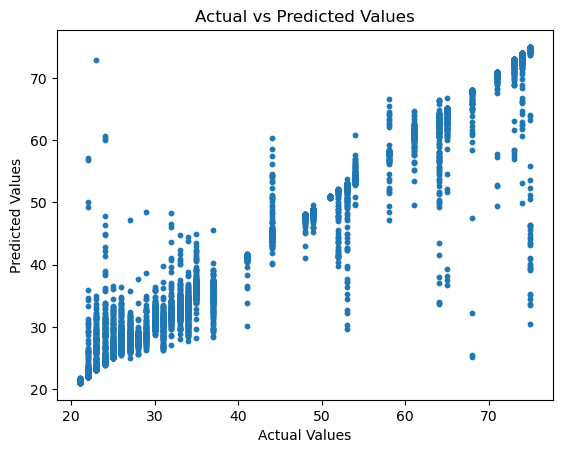

In [206]:
plt.scatter(y_test, y_pred, s=10, label='True')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

In [196]:
# 初步結果
# Mean Squared Error (MSE): 0.8683906792346255
# Mean Absolute Error (MAE): 0.09208324507519595
# 訓練集:  0.9991589359782412
# 測試集:  0.9945260498860083
# Pearson correlation: 0.9972625885780086